# Simple Neural Network Using Numpy

   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="600" />   <center/>


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import tensorflow as tf

from lab_utils_common import dlc, sigmoid
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## DataSet

In [4]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


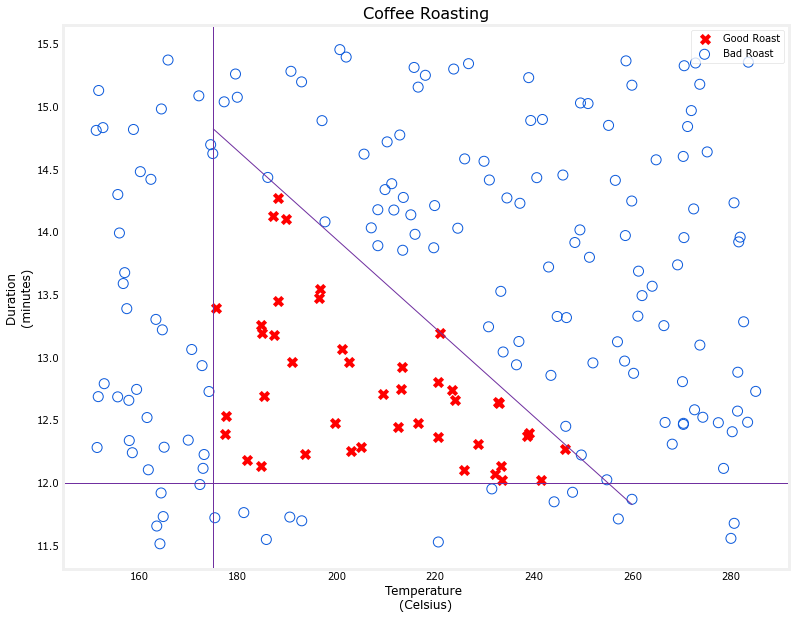

In [7]:
plt.rcParams["figure.figsize"] = (13,10)
plt_roast(X,Y)

### Normalize Data

In [9]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X) 
Xn = norm_l(X)

print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


## Numpy Model (Forward Prop in NumPy)
<center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="400" />   <center/>  

It is possible to build our own dense layer using NumPy. This can then be utilized to build a multi-layer neural network. 

<center> <img src="images/C2_W1_dense3.png" width="650" height="450"> <center/>  

A layer simply contains multiple neurons/units. One can utilize a for loop to visit each unit (`j`) in the layer and perform the dot product of the weights for that unit (`W[:,j]`) and sum the bias for the unit (`b[j]`) to form `z`. An activation function `g(z)` can then be applied to that result.

First, we define the activation function `g(x)`, which is a sigmoid function $\frac{1}{1+e^{-x}}$ in this case. We can use the `sigmoid()` function which is already implemented in the `lab_utils_common.py` file.

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500)           # Protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

Given an interval, `np.clip` clips the values outside the interval to the interval edges. For example, if an interval of [-500, 500] is specified, values smaller than -500 become -500, and values larger than 500 become 500.

In [11]:
# Define the activation function
g = sigmoid
type(g)

function

Next, define the dense layer  `my_dense()` function which computes the activations of a dense layer.

<center> <img src="images/numpy_nn_implementation.png" width="750" height="550"> <center/>  

In [18]:
def my_dense(a_in, W, b):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : 1 example or row of the data
      W    (ndarray (n, j)) : weight matrix, n features (number of columns of design matrix minus intercept column) per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
    Returns
      a_out (ndarray (j,))  : j units|
    """
    # Obtain the number of units (neurons) in the layer from the second axis of the weight matrix (columns)
    # Each column of the weight matrix is a vector of weights for a unit, so j units means j columns in the weight matrix
    units = W.shape[1]
    # Initialize the vector of activation values to zeros
    a_out = np.zeros(units)
    for j in range(units):               
        w = W[:,j] # Subset the jth column of the weight matrix, a vector of weights w for the jth unit                        
        z = np.dot(w, a_in) + b[j] # Compute linear predictor z = w^T a_in + b for the jth unit       
        a_out[j] = g(z) # Compute activation value (logit transformation) a_out[j] = g(z) for the jth unit             
    return a_out

*Note*: We can also implement the function above to accept `g` as an additional parameter (e.g. `my_dense(a_in, W, b, g)`). In this notebook though, we will only use one type of activation function (i.e. sigmoid) so it's okay to make it constant and define it outside the function in the enclosing (global) scope of the function.

The following cell builds a two-layer neural network utilizing the `my_dense` subroutine above.

In [19]:
# Two-layer network
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1) # First vector of activations
    a2 = my_dense(a1, W2, b2) # Second vector of activations, using the first vector of activations as input
    return a2

We can copy trained weights and biases from the previous notebook using Tensorflow.

In [24]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

print('Parameters for the first layer', W1_tmp.shape, b1_tmp.shape, '\n')
print('Parameters for the second layer', W2_tmp.shape, b2_tmp.shape)

Parameters for the first layer (2, 3) (3,) 

Parameters for the second layer (3, 1) (1,)


The first layer has weight matrix with shape `(2, 3)` since there are two features in the training data row or example $\underbrace{\vec{x}}_{2 \times 1}$ and three units in the layer. The second layer has weight matrix with shape `(3, 1)` since the input vector if activation $\underbrace{\vec{a}^{[1]}}_{3 \times 1}$ has three elements and one unit.

### Predictions 

<center> <img src="./images/C2_W1_RoastingDecision.PNG" width="450" height="300" ><center/> 

To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5. Let's start by writing a routine similar to Tensorflow's `model.predict()`. This will take a matrix $X$ with all $m$ training examples in the rows and make a prediction by running the model.

In [29]:
def my_predict(X, W1, b1, W2, b2):
    """
    Make predictions for a two-layer neural network

    Parameters
    ----------
    X : ndarray (m, n)
        Training data consisting of m examples (rows) of n features (columns)
    W1 : ndarray (n, j)
        Weight matrix for the first layer, n features (number of columns of design matrix minus intercept column) per unit, j units
    b1 : ndarray (j, )
        Bias vector for the first layer, j units or elements
    W2 : ndarray (j, 1)
        Weight matrix for the second layer, j units per unit or neuron, 1 unit
    b2 : ndarray (1, )
        Bias vector for the second layer, 1 unit or element
    """
    # Number of training examples or rows
    m = X.shape[0]
    # Initialize the vector of predictions to zeros (two-dimensional array with one column)
    p = np.zeros((m,1))
    # For each row of training data
    for i in range(m):
        # The ith row and first column (0 is needed since we initialized p to be a two-dimensional array)
        # We obtain the X[i] row of the training data
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
        
    return p

We can try this routine on two examples:

In [30]:
X_tst = np.array([
    [200,13.9],  # Positive example
    [200,17]])   # Negative example
X_tstn = norm_l(X_tst)  # Normalize test data using the normalization layer learned from the training data
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

To convert the probabilities to a decision, we apply a threshold:

In [31]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [32]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Network function

This graph shows the operation of the whole network and is identical to the Tensorflow result from the previous lab.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's. The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  

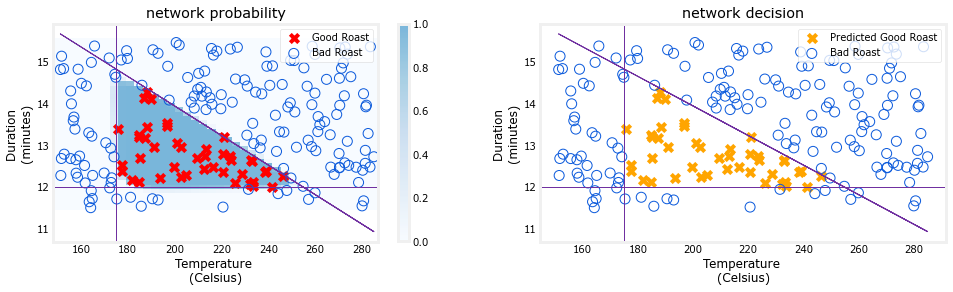

In [33]:
netf= lambda x : my_predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)